In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis = 0)
train_data = shuffle(train_data, random_state = 42)

X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

noise_all = pd.concat([noise_real, noise_syn], axis = 0)

scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])
X = scaler.transform(X)

X = np.expand_dims(X, axis=-1)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     MaxPooling1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def build_best_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)

    x = Conv1D(64, 8, padding='same')(x)  # input is now 4096 length
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)      # down to 1024

    x = Conv1D(128, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)      # 256

    x = Conv1D(256, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)      # 64

    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [4]:
model = build_best_cnn()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,  # reduced from 32
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/30
1792/1792 [==============================] - 35s 16ms/step - loss: 0.6481 - accuracy: 0.5954 - val_loss: 0.6239 - val_accuracy: 0.7168
Epoch 2/30
1792/1792 [==============================] - 27s 15ms/step - loss: 0.4280 - accuracy: 0.7542 - val_loss: 0.4942 - val_accuracy: 0.7174
Epoch 3/30
1792/1792 [==============================] - 28s 16ms/step - loss: 0.3796 - accuracy: 0.7768 - val_loss: 0.6142 - val_accuracy: 0.7294
Epoch 4/30
1792/1792 [==============================] - 28s 16ms/step - loss: 0.3589 - accuracy: 0.7921 - val_loss: 0.5510 - val_accuracy: 0.7634
Epoch 5/30
1792/1792 [==============================] - 29s 16ms/step - loss: 0.3462 - accuracy: 0.8002 - val_loss: 0.4130 - val_accuracy: 0.8039
Epoch 6/30
1792/1792 [==============================] - 28s 16ms/step - loss: 0.3345 - accuracy: 0.8126 - val_loss: 0.4315 - val_accuracy: 0.7729
Epoch 7/30
1792/1792 [==============================] - 27s 15ms/step - loss: 0.3279 - accuracy: 0.8226 - val_loss: 0.3474 -

112/112 [==============================] - 2s 11ms/step
ROC AUC Score: 0.933517767458546
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      1792
         1.0       0.90      0.76      0.82      1792

    accuracy                           0.84      3584
   macro avg       0.85      0.84      0.84      3584
weighted avg       0.85      0.84      0.84      3584



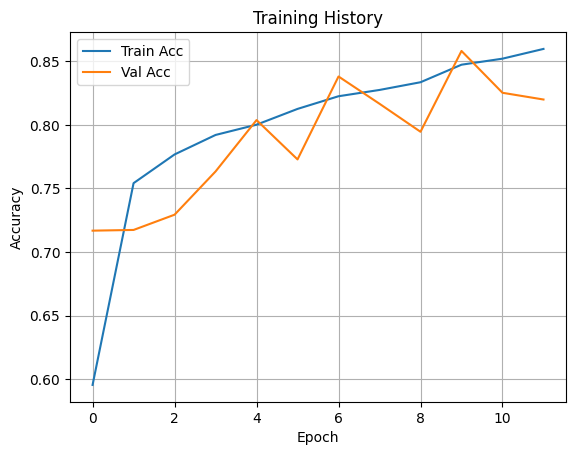

In [5]:
y_pred = model.predict(X_val).ravel()

from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [6]:
model.save("final_pure_cnn_model.h5")